# Time series analysis and predictive regression model on 'Road Accident in the City of Austin':

#### Importing required python modules:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import folium.plugins
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, \
             ParameterGrid, cross_val_score, GridSearchCV, cross_val_predict, \
             RandomizedSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, \
             mean_squared_error, r2_score, explained_variance_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from collections import defaultdict
%matplotlib inline


#### Import tidy dataset file saved as .csv format

In [2]:
# Import the datafile
df0 = pd.read_csv('data_with_WSigLmrkSol.csv', parse_dates=['Date'],
                  index_col='Date')
# Delete the unnecessary column appeared in the input file
df0.drop(columns='Unnamed: 0', axis=1, inplace=True)
# Info of the data

#### Function to calculate the errors:

In [3]:
# This function calculates errors:
# R_squared, RMSE and MAPE


def rmse_mae(actual, predicted):
    r_square = r2_score(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(abs(actual - predicted) / np.mean(abs(actual)))
    print('R_Square: %.2f' % r_square,
          '\nRoot mean squared error (RMSE): %.3f' % rmse,
          '\nThe mean absolute percentage error (MAPE): %.2f'
          % (100*mape), '''%''',
          '\nAccuracy: %.0f' %(100*(1-mape)),'''%''')
    return r_square, rmse, mape

# 1. Time Series Forecasting Models:

#### Univariate time series data:
Assuming the road accidents vary with time, we consider the time series analysis as the first statistical model to forecast the future road accidents. Therefore, we will discuss simple time series analysis tools like autoregressive integrated moving average (ARIMA) model. Before starting with ARIMA, we develop and analyze a baseline model that takes the incident from history and forecast for future. 

First of all, we extract daily accident counts in the city of Austin as time series data.   

In [14]:
# Calculate the total daily accidents
df = pd.DataFrame(df0.groupby('Date').sum()['Accident'])

## A. Baseline Model:

#### Persistence forecast model:
In this model, we assume that one of the past values persists as the data in future, i.e. we expect the periodic repetition of the event. We plot the root mean squared error (RMSE) as a function of time. 
The minimum RMSE corresponds to the required point of time to fore cast the event.  

In our data series, as plotted in figure below, minimum RMSE is repeated every interval of 7. Therefore, we forecast the next value as that happened a week ago. 

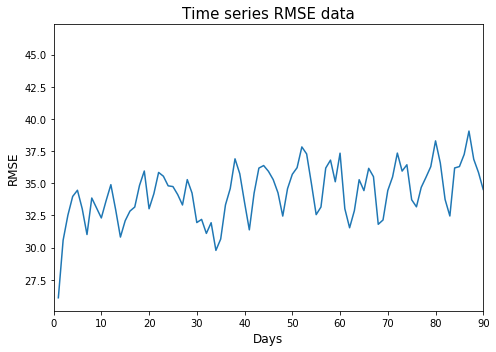

In [15]:
# Persistence Forecast Algorithm:

# The daily accident data
X = df.Accident.values
# First 'length' data are set to be training data set
length = 600
# Length of the test data
p_length = int(len(X) - length)
# Split the train test sets of time series data
train, test = X[0: -length], X[-p_length:]
# The number of data points to be used for forecast
persistence_values = range(1, p_length)
#
scores = list()
for p in persistence_values:
    # walk-forward validation
    history = [x for x in train]
    predictions = []
    for i in range(len(test)):
        # make prediction
        yhat = history[-p]
        predictions.append(yhat)
        # observation
        history.append(test[i])
    rmse = np.sqrt(mean_squared_error(test, predictions))
    scores.append(rmse)
    # print('p = %d RMSE: % .3f' % (p, rmse))
# plot scores over persistence values
fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(persistence_values, scores)
plt.xlabel('Days', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.xlim(0, 90)
plt.title('Time series RMSE data', fontsize=15)
plt.tight_layout()
plt.savefig('baseline_persistence_model.pdf')

#### Plot fo baseline model forecasting based on data 7 days back:

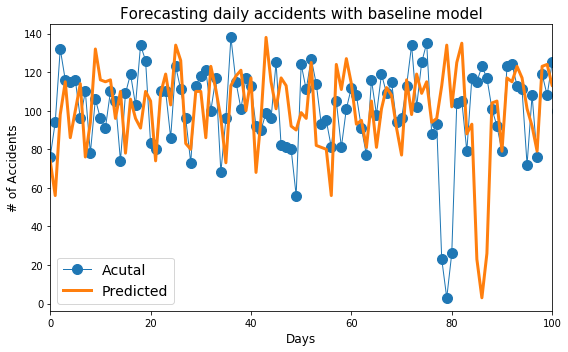

In [16]:
# Now, make predictions as the forecast for the future test set of data.
# The pattern of the rmse shows the minima of errors are every 7th day.
# Therefore, the forecast is based on the data occurred on 7 day ago.
history = [x for x in train]
predictions = []
for i in range(len(test)):
    # make prediction
    yhat = history[-7]
    predictions.append(yhat)
    # observation
    history.append(test[i])
# plot predictions vs observations
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(test, linewidth=1, label='Acutal', marker='o', markersize=10.0, )
plt.plot(predictions, linewidth=3.0, label='Predicted')
plt.legend(loc=4, fontsize=14)
plt.xlim(0, 100)
plt.xlabel('Days', fontsize=12)
plt.ylabel('# of Accidents', fontsize=12)
plt.title('Forecasting daily accidents with baseline model', fontsize=15)
plt.legend(loc=3, fontsize=14)
plt.tight_layout()
plt.savefig('baseline_persistnece_forecasting.pdf')

#### Errors:
This algorithm performs with error RMSE ~31 accidents daily in Austin. MAPE of 21.12% which means this algorithm has accuracy of 77.88%

In [17]:
# Calculate the errors, rmse and mean absolute percentage error. 
baseline_rsq, baseline_rmse, baseline_mape = rmse_mae(test, predictions)

R_Square: -0.88 
Root mean squared error (RMSE): 31.019 
The mean absolute percentage error (MAPE): 21.12 % 
Accuracy: 79 %


#### Rollong window model: 
We want to apply better model using rolling window technique which improves the baseline model. Instead of taking a particular value from the history, we take a mean of data in a window from the past and slide the window to forecast the future data. To find the optimum size of the window, we calculate the RMSE of predicted values and choose the size corresponding to the minimum RMSE.

From the calculation and figure below, we found the window size of 99 days will produce the minimum error. Therefore, we predict the future value as the mean of accidents happened in the past 99 days. 

Window with minimum RMSE:  99 
Minimum RMSE:  22.60259331715401


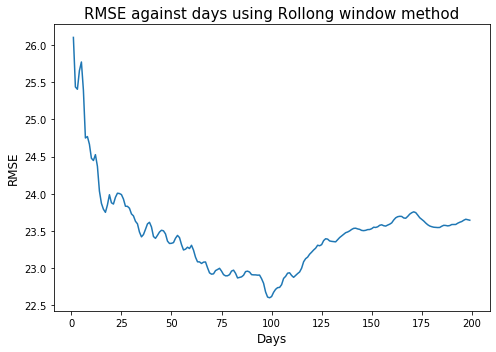

In [18]:
# Rolling Window model:
rmss = 100
window_sizes = range(1, 200)
scores = []
for w in window_sizes:
    # walk-forward validation
    history = [x for x in train]
    predictions = []
    for i in range(len(test)):
        # make prediction
        yhat = np.mean(history[-w:])
        predictions.append(yhat)
        # observation
        history.append(test[i])
    # report performance
    rmse = np.sqrt(mean_squared_error(test, predictions))
    scores.append(rmse)
    if rmse < rmss:
        rmss = rmse
        ww = w
    # print('w = %d RMSE: %.3f' % (w, rmse))
print('Window with minimum RMSE: ', ww, '\nMinimum RMSE: ', rmss)
# plot scores over window sizes values
fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(window_sizes, scores)
plt.xlabel('Days', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('RMSE against days using Rollong window method', fontsize=15)
plt.tight_layout()
plt.savefig('Rolling_window_baseline.pdf')

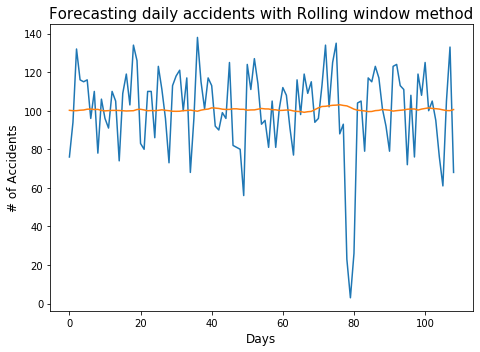

In [19]:
# Prediction made using the window with minimum rmse:
predictions = []
for i in range(len(test)):
    # make prediction
    yhat = np.mean(history[-99:])
    predictions.append(yhat)
    # observation
    history.append(test[i])
# plot predictions vs observations
fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(test)
plt.plot(predictions)
plt.xlabel('Days', fontsize=12)
plt.ylabel('# of Accidents', fontsize=12)
plt.title('Forecasting daily accidents with Rolling window method',
          fontsize=15)
plt.tight_layout()
plt.savefig('rolling_window_prediction.pdf')

#### Errors:

In [20]:
rw_rsq, rw_rmse, rw_mape = rmse_mae(test, predictions)

R_Square: -0.02 
Root mean squared error (RMSE): 22.791 
The mean absolute percentage error (MAPE): 17.05 % 
Accuracy: 83 %


Although this produces improved accuracy than that by previous model, after observing the graph, we can see this model only forecast the trend. The up and down values are not predicted well.

## B. ARIMA model: 

Now we use a regression model which learn from the past data and predict the future. 
One popular model is autoregressive moving average which uses the linear regression 
method to learn from the past data points (training set).
A condition for application of this method is taht the past data should be independent to each other,
i.e. the time series data should be stationary. If the time series data has some trend, then the ARIMA algorithm uses the differentials until it becomes stationary.
ARIMA has three steps: make series stationary (differentiation with degree 'd'), learn from the 
past data points (autoregression with number of past data 'p') and moving average of the past values (controlled by parameter 'd'). Therefore, ARIMA is a model controlled by three parameters (p, d, q).


To check whether the data is stationary or not, we apply adfuller-test. 
The null hypothesis is: the time series is not stationary or differentiation is required. 
One component of test-result is p-value which will determine if we need to differentiate or not.

#### Adfuller test 

In [21]:
# To check the stationarity of the time series we check the daily
# accident data by using ad-fuller test.
# The adfuller is already imported from the python statsmodel library.
# We use the adfuller here.
result = adfuller(df.Accident)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -5.180979
p-value: 0.000010


Since the p-value is < 0.05, null hypothesis is rejected, i.e. the data is stationary and differentiation is not required. Integrated term from ARIMA can be neglected which means just ARMA.

#### Autocorrelation and Partial atuocorrelation:

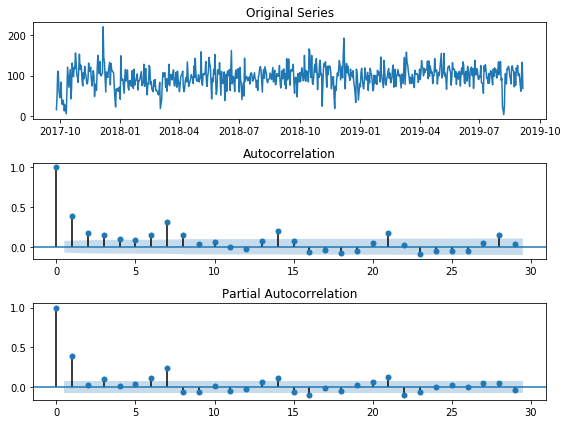

In [22]:
# To figure out the parameters p (AR) and q (MA) of our
# time series forecasting model, we calculate the correlogram:
# Plot the acf and pacf
fig, axes = plt.subplots(3, 1, figsize=(8, 6))
axes[0].plot(df.Accident)
axes[0].set_title('Original Series')
plot_acf(df.Accident, ax=axes[1])
plot_pacf(df.Accident, ax=axes[2])
plt.tight_layout()
plt.savefig('auto_pauto.pdf')

To know the values of autoregression steps (p) and moving average steps (q), we plot the autocorrelation and 
partial auto-correlation functions. 


In the acf plot there are first 3 lags out of significance level. 
So, we choose q = 3. From the pacf, the data points are out of significance level upto lags = 2, so, we choose p = 2. We choose the value of d = 0, since the time series data is stationary as seen from adfuller test above. 

#### Splitting train and test datasets:

In [23]:
# We split the dataset into train and test sets as a
# fraction of the original data 
test_size = 0.2
train_len = int((1 - test_size) * len(df.Accident))
test_len = len(df.Accident) - train_len
# print the train and lest size here:
print('Size of train set: ',
      train_len, '\nSize of test set: ', test_len)
y_train = df.Accident[:train_len]
y_test = df.Accident[train_len:]

Size of train set:  567 
Size of test set:  142


### a. ARIMA with only time series data set (Target):

#### Forecasting the next value as autoregressive moving average:

In [24]:
# 2, 0, 3 ARIMA Model with target variable y_train 
model = ARIMA(y_train, order=(2,0,3))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:               Accident   No. Observations:                  567
Model:                     ARMA(2, 3)   Log Likelihood               -2613.846
Method:                       css-mle   S.D. of innovations             24.307
Date:                Mon, 23 Dec 2019   AIC                           5241.691
Time:                        13:54:08   BIC                           5272.074
Sample:                    09-26-2017   HQIC                          5253.549
                         - 04-15-2019                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             94.9161      1.632     58.170      0.000      91.718      98.114
ar.L1.Accident     0.3782      0.224      1.685      0.093      -0.062       0.818
ar.L2.Accident    -0.4910      0.125

#### Forecasting the future data corresponding to the test data sets:

In [25]:
# For forecasting the data corresponding to the test set
# (y_test) we use the rolling window model.
# Rolling window ARIMA
predictions = []
history = [x for x in y_train]
for t in range(len(y_test)):
    model = ARIMA(history, order=(2, 0, 3))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0][0]
    obs = y_test[t]
    predictions.append(yhat)
    history.append(obs)

#### Plotting the test and forecast datasets:
We see better match of forecast to actual test data than that for the baseline model. 

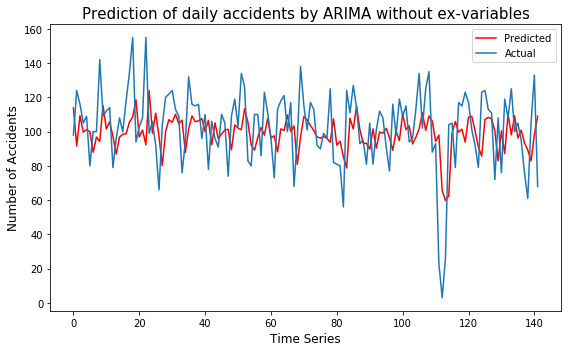

In [26]:
# y_test data are for the last 142 days.
ytest = y_test.reset_index().drop('Date', axis=1)
# plot
fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(predictions, color='red', label='Predicted')
plt.plot(ytest, label='Actual')
plt.legend()
plt.xlabel('Time Series', fontsize=12)
plt.ylabel('Number of Accidents', fontsize=12)
plt.title('Prediction of daily accidents by ARIMA without ex-variables', fontsize=15)
plt.tight_layout()
plt.savefig('arima_without_ex-variables.pdf')

#### Errors:

In [27]:
arma_rsq, arma_rmse, arma_mape = rmse_mae(y_test, predictions)
# Performance of ARMA over baseline
rsq_perf = (baseline_rsq - arma_rsq)/baseline_rsq
rmse_perf = (baseline_rmse - arma_rmse)/baseline_rmse
mape_perf = 100 * (baseline_mape - arma_mape)/baseline_mape
print('\nPerfomance over baseline model: ')
print('MAPE: %.0f' % mape_perf, '%')#, 'R-Square: %.2f' %rsq_perf, 'RMSE: %.2f' %rmse_perf)
print('')
print('From the analysis of the errors, this method outperforms by 20% as expected.\n')

R_Square: 0.03 
Root mean squared error (RMSE): 21.830 
The mean absolute percentage error (MAPE): 16.92 % 
Accuracy: 83 %

Perfomance over baseline model: 
MAPE: 20 %

From the analysis of the errors, this method outperforms by 20% as expected.



Mean: 0.0459 
Standard deviation: 23.7808


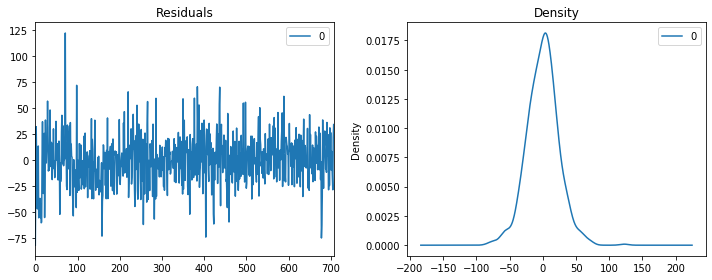

In [28]:
residuals = pd.DataFrame(model_fit.resid)
print('Mean: %.4f' % np.mean(residuals),
      '\nStandard deviation: %.4f' % np.std(residuals))
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.tight_layout()

Residulas are distributed with mean close to zero (0.0458) and with standard deviation 23.78.





.

.



Both of the RMSE and MAPE are better than that obtained from the baseline models. It will better if we include the other features as exogeneous variables.  

### b. ARIMA with exogeneous variables:

Although ARIMA for the univariate time series performs better than the baseline model, the traffic accidents are caused by the influence of several spatial and temporal variables. So, we proceed ARIMA with exogeneous variables (external variables that enhances the chance of traffic accidents).  

#### Feature selection:

In [29]:
# Features (exogeneous variables) mean daily values
X = df0.groupby(['Date']).mean()[['Longitude', 'Latitude', 'windSpeed',
                                  'visibility', 'pcpt_mmph', 'temperature',
                                  'dewPoint', 'humidity','DayOfWeek',
                                  'day','month']]
# Target (endogeneous variable)
y = df

#### Train, test split:

In [30]:
X_train = X[:train_len]
X_test = X[train_len:]
y_train = y[:train_len]
y_test = y[train_len:]

#### Train the model and forecast with ARIMA

In [31]:
# X_train are included as exogeneous varaibles:
model = ARIMA(endog=y_train, exog=X_train, order=(2, 0, 3))
fitted = model.fit()

# Forecast
fc, se, conf = fitted.forecast(test_len, exog=X_test, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=y_test.index)
lower_series = pd.Series(conf[:, 0], index=y_test.index)
upper_series = pd.Series(conf[:, 1], index=y_test.index)

/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


#### Plot the test set of data and forecasted with training data:

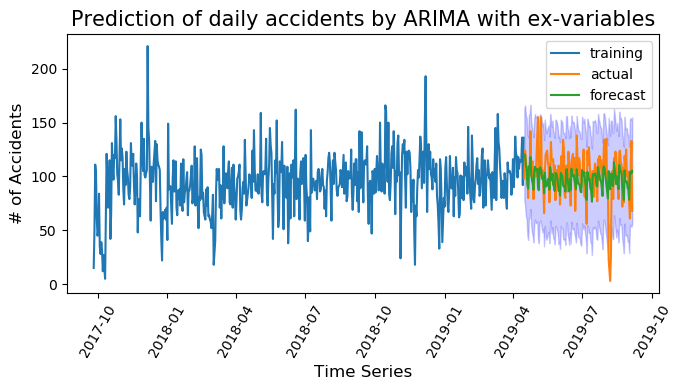

In [32]:
# Plot
plt.figure(figsize=(7, 4), dpi=100)
plt.plot(y_train, label='training')
plt.plot(y_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='b', alpha=.2)
plt.xlabel('Time Series', fontsize=12)
plt.ylabel('# of Accidents', fontsize=12)
plt.xticks(rotation=60)
plt.title('Prediction of daily accidents by ARIMA with ex-variables', fontsize=15)
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.savefig('Arima_prediction.pdf')

In [33]:
exar_rsq, exar_rmse, exar_mape = rmse_mae(y_test.Accident, fc)
rsq_perf = (baseline_rsq - exar_rsq)/baseline_rsq
rmse_perf = (baseline_rmse - exar_rmse)/baseline_rmse
mape_perf = 100 * (baseline_mape - exar_mape)/baseline_mape

print('')
rsq_perf_ex = (arma_rsq - exar_rsq)/arma_rsq
rmse_perf_ex = (arma_rmse - exar_rmse)/arma_rmse
mape_perf_ex = 100 * (arma_mape - exar_mape)/arma_mape


print('From the analysis of errors,'
      'this method outperforms the "baseline" model by {0:.0f} % \n'
      'and "ARIMA without exogeneous variables" model by {1:.0f}' \
      .format(mape_perf, mape_perf_ex),'%')

R_Square: 0.06 
Root mean squared error (RMSE): 21.440 
The mean absolute percentage error (MAPE): 15.16 % 
Accuracy: 85 %

From the analysis of errors,this method outperforms the "baseline" model by 28 % 
and "ARIMA without exogeneous variables" model by 10 %


As expected we get the better performance when we include the exogeneous variables. 

Mean: 0.3167 
Standard deviation: 22.1805


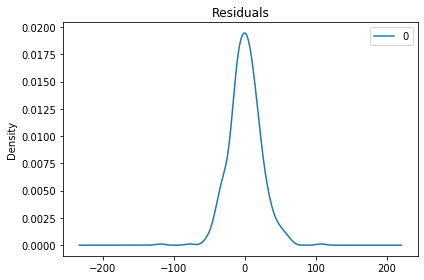

In [34]:
residuals = pd.DataFrame(fitted.resid)
print('Mean: %.4f' % np.mean(residuals),
      '\nStandard deviation: %.4f' % np.std(residuals))
fig, ax = plt.subplots(figsize=(6, 4))
residuals.plot(kind='kde', title="Residuals", ax=ax)
# residuals1.plot(kind='kde', title='Residuals1', ax=ax[1])
plt.tight_layout()
plt.savefig('Arima_residual.pdf')

# 2. Decision Tree Models:

From the time series analysis of the daily accidents, we see that the series does not follow any trend and seasonality. In this section we build predictive model to forecast the daily average of road accidents in the city of Austin. We will dive deeper to predict the daily average of road accidents at higher resolution of geographical locality. Finally, we will make some predictions of average accidents each hour of any day in the city of Austin. 

We apply two separate predictive machine learning model based on decision tree: (i) Random Forest regressor (train a number of trees at a time and average over the results from trees to get the final results) and (ii) extreme gradient boosting regressor (learn from the previous tree and train the next one to get the final results).


## A. Random Forest Regressor Model:

#### Function for feature selection:

In [4]:
def filter_data(data_read, one_hot_encod=0, label_encod=0):  # This function filter the data
    if one_hot_encod == label_encod == 1:
        print('We will not apply both encoding at once')
        return 
    df1 = data_read[['Accident','Location']].groupby(['Date', 'Location']).sum()
    df2 = data_read[['Latitude', 'Longitude', 'Signals', 'Schools',
                     'Landmarks', 'windSpeed', 'visibility',
                     'pcpt_mmph', 'temperature', 'dewPoint',
                     'Solar_inclination',
                     'humidity', 'Location']].groupby(['Date', 'Location']).mean()

    df_obj1 = data_read[['Holiday', 'Weather', 'Location']].groupby(['Date', 'Location']).max()
    df_obj2 = data_read[['DayOfWeek', 'hour', 'day', 'month', 'year', 'Location']].groupby(['Date', 'Location']).max()
    # One-hot-encoding using pandas get_dummies for the categorical
    # variables 'day', 'DayOfWeek', 'hour', 'month'.
    if one_hot_encod:
        # Convert the type of categorical variables into string. 
        df_obj2 = df_obj2.apply(str)
        df_obj = data_read[['Holiday', 'Weather','Location',
                         'DayOfWeek', 'hour', 'day', 'month', 'year']]
        print('cat variables converted to string')
        df3 = pd.get_dummies(pd.DataFrame(
              df_obj.groupby(['Date', 'Location']).max()))
    elif label_encod:
        print('label encoding started')
        df_le = df_obj1.apply(LabelEncoder().fit_transform)
        print('label_encoding ended')
        df3 = pd.merge(df_le, df_obj2, on=['Date', 'Location'], how='inner')
    else:
        df3 = pd.DataFrame(df_obj.groupby(['Date', 'Location']).max())
    # Merge the dataframes to get a single data files
    # after grouping for daily accidents and chaning the categorical variables.
    dfd_mid = pd.merge(df2, df3, on=['Date', 'Location'], how='inner')
    df_d = pd.merge(dfd_mid, df1, on=['Date', 'Location'], how='inner')
    return df_d

#### Splitting data into train and test set.

In [5]:
# This function will split the dataset into train and test set
# It will split the data first certain fraction of data as
# train data and remaining later portion as test data.

def split_data(input_data, time_series=True, test_size=0.2, seed=42):
    data_feature = input_data.iloc[:, :-1]
    data_target = input_data.iloc[:, -1]
    
    if time_series:
        test_len = int(len(input_data) * test_size)
        xn = data_feature.iloc[:-test_len, :]
        xt = data_feature.iloc[-test_len:, :]
        yn = data_target.iloc[:-test_len]
        yt = data_target.iloc[-test_len:]
    else:
        # It will split the whole dataset in a random way
        xn, xt, yn, yt = train_test_split(data_feature,
                                          data_target,
                                          test_size=test_size,
                                          random_state=seed)
    return xn, xt, yn, yt, data_feature.columns

In [6]:
df_d = filter_data(df0, one_hot_encod=1)

cat variables converted to string


#### Split the data into train test set 

In [7]:
Xd_train, Xd_test, yd_train, yd_test, col_list = \
                    split_data(df_d, time_series=True)

#### Create the pipe for regression model followed by dimensionality reduction using PCA:

In [8]:
# Instantiate a random forest regressor with standardize and
# reduction of dimension by PCA
predictor = []
predictor.append(('scaler', StandardScaler()))
predictor.append(('pca', PCA()))
predictor.append(('rf', RandomForestRegressor(random_state=22)))
pipe = Pipeline(predictor)

#### Cross validation: $R^2$-score vs k-fold cross-validation

In [9]:
scores = []
for i in range(2, 10):
    mscore=cross_val_score(pipe, Xd_test, yd_test, cv=i).mean()
    scores.append(mscore)

/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 t

/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 t

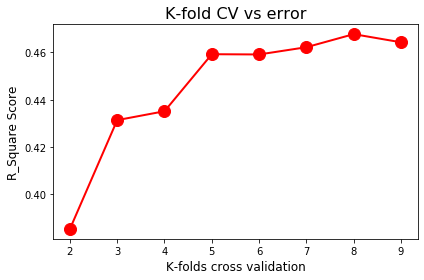

In [32]:
plt.plot(range(2, 10), scores, linewidth=2, marker='o', color='r', markersize=12)
plt.xlabel('K-folds cross validation', fontsize=12)
plt.ylabel('R_Square Score', fontsize=12)
plt.title('K-fold CV vs error', fontsize=16)
plt.tight_layout()
plt.savefig('rf_cv.pdf')

#### Tuning the Hyperparameters using RandomizedSearchCV:

In [33]:
# Setup the hyperparameter grid for a random forest gridsearch
param_grid = {'rf__max_features': np.arange(0.4, 1.0, 0.2),
              'rf__n_estimators': np.arange(100, 200, 20),
              'rf__criterion': ['mse'],#, 'mae'],
              'rf__bootstrap': [True],#, False],
              'rf__verbose': [1],
              'rf__max_depth': np.arange(4, 10, 1)}

In [ ]:
# Instantiate the RandomizedSearchCV object:
model_cv = RandomizedSearchCV(pipe, param_grid, cv=5,
                              n_iter=50, n_jobs=-1, verbose=0)
# Fit it to the datac
model_cv.fit(Xd_train, yd_train)

# Print the tuned parameters and score
print("Tuned Random Forest Parameters: {}".format(model_cv.best_params_))
print("Best score is {}".format(model_cv.best_score_))

#### Train the model using the best set of parameters to the RandomForestRegressor:
From the training with lists of parameters, we have predicted for the test set of the data and compared the predicted data to the actual test set of target values. The test $R^2$ score which is default scoring for random forest regressor is obtained to be ~0.56

In [42]:
estimator = []
estimator.append(('scaler', StandardScaler()))
estimator.append(('reduce_dim', PCA()))
estimator.append(('regressor', 
                  RandomForestRegressor(n_estimators=90,
                                        max_features=0.6,
                                        criterion='mse',
                                        bootstrap=True,
                                        verbose=1)))
pipe = Pipeline(estimator)
pipe.fit(Xd_train, yd_train)
print(pipe.score(Xd_test, yd_test))
# Format the data series after geting output from the fit
yd_pred = pd.DataFrame(pipe.predict(Xd_test),
                       columns=['Predicted']).reset_index()
# Merge the test data and predicted data
y_out = pd.merge(yd_test.reset_index().reset_index(),
                 yd_pred, on='index',
                 how='inner').drop('index', axis=1)
# get the data grouped by column 'Date'
# to get the daily aggregate accident throughout the city
yd_ap = pd.merge(yd_test.reset_index().reset_index(),
                 yd_pred, on='index',
                 how='inner').drop('index',
                                   axis=1).groupby('Date').sum()
# get the data grouped by column 'Location' to get the
# daily accidents at each of the choosen locations
yl_ap = pd.merge(yd_test.reset_index().reset_index(),
                 yd_pred, on='index',
                 how='inner').drop('index',
                                   axis=1).groupby('Location').sum()
# get the feature importances
feat_importances = pd.Series(pipe.steps[2][1].feature_importances_,
                             index=Xd_train.columns)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   38.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.5463749894824894


[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:    0.1s finished


In [43]:
r_rsq, r_rmse, r_mape = rmse_mae(y_out.Accident, y_out.Predicted)


R_Square: 0.55 
Root mean squared error (RMSE): 1.194 
The mean absolute percentage error (MAPE): 38.02 % 
Accuracy: 62 %


#### Plot the Feature Importances:
From the feature importance, the daily average of the accidents in Austin is mainly influenced by spatial location. Longitude is the most important feature for the road accidents. This is not different from the general intuition because the city is situated expanding from North to South. This means more accidents occur in the proximity of the high-speed highways which are oriented along the longitude. All other features have almost similar weightages with respect to this model.

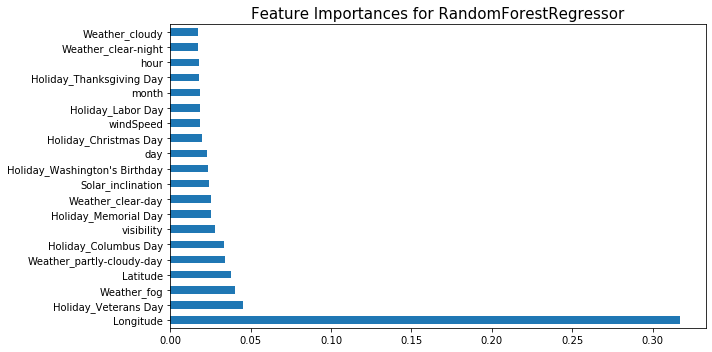

In [44]:
fig, ax = plt.subplots(figsize=(10, 5))
feat_importances.nlargest(20).plot(kind='barh', ax=ax)
plt.title('Feature Importances for RandomForestRegressor', fontsize=15)
plt.tight_layout()
plt.savefig('RandomForestRegressor.pdf')

In [46]:
from 
dot_data = tree.export_graphviz(clf, out_file='tree.dot') 

NameError: name 'tree' is not defined

#### Plot the predicted and actual number of accidents for the test set. The trained set of data are also shown.

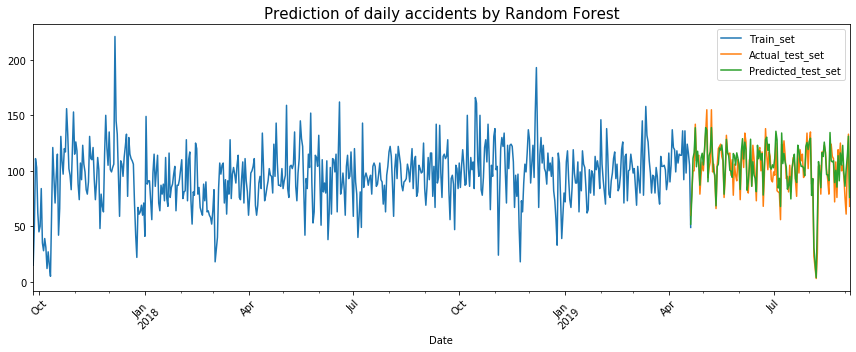

In [12]:
yd_train = yd_train.groupby('Date').sum()

fig, ax = plt.subplots(figsize=(12, 5))
yd_train.plot(ax=ax, label='Train_set')
plt.legend()
yd_ap.rename(columns={'Accident': 'Actual_test_set',
                      'Predicted': 'Predicted_test_set'}). \
           plot(ax=ax)
plt.xticks(rotation=45)
ax.set_title('Prediction of daily accidents by Random Forest', fontsize=15)
plt.tight_layout()
plt.savefig('rf_daily_prediction.pdf')

In [35]:
rf_rsq, rf_rmse, rf_mape = rmse_mae(yd_ap.Accident, yd_ap.Predicted)

# Calculate the performance over the previous models
rsq_perf_rf = abs(rf_rsq-baseline_rsq)/baseline_rsq
rmse_perf_rf = abs(rf_rmse-baseline_rmse)/baseline_rmse
mape_perf_rf = 100*abs(rf_mape-baseline_mape)/baseline_mape
print('')
rsq_perf_rf1 = abs(rf_rsq-exar_rsq)/exar_rsq
rmse_perf_rf1 = abs(rf_rmse-exar_rmse)/exar_rmse
mape_perf_rf1 = 100*abs(rf_mape-exar_mape)/exar_mape


print('From the analysis of errors, '
      'this method outperforms the "baseline" model by {0:.0f} % \n'
      'and "ARIMA without exogeneous variables" model by {1:.0f}' \
      .format(mape_perf_rf, mape_perf_rf1),'%')

R_Square: 0.75 
Root mean squared error (RMSE): 11.401 
The mean absolute percentage error (MAPE): 8.61 % 
Accuracy: 91 %

From the analysis of errors, this method outperforms the "baseline" model by 59 % 
and "ARIMA without exogeneous variables" model by 43 %


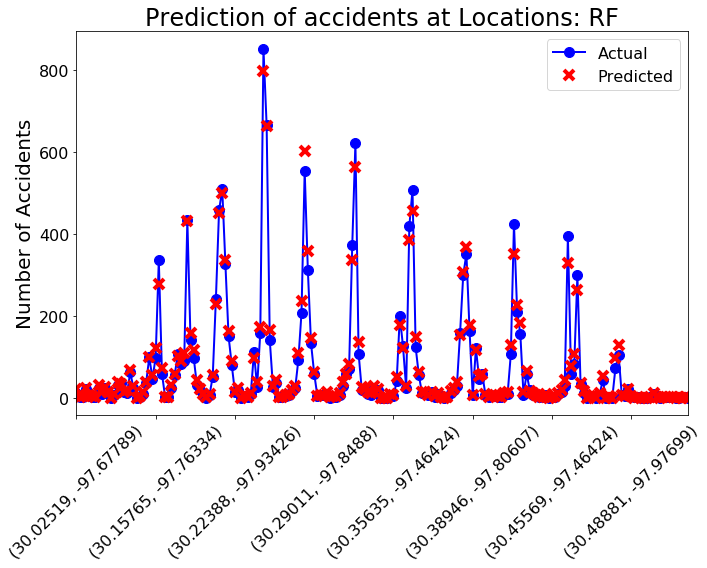

In [74]:
fig, ax = plt.subplots(figsize=(10, 8))
yl_ap['Accident'].plot(label='Actual',
                       marker='o',
                       markersize=10,
                       linewidth=2,
                       color='b',
                       ax=ax)
yl_ap['Predicted'].plot(label='Predicted',
                        marker='x',
                        markersize=10,
                        markeredgewidth=4,
                        linewidth=0, 
                        ax=ax,
                        color='r')
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.xlabel('')
plt.ylabel('Number of Accidents', fontsize=20)
plt.title('Prediction of accidents at Locations: RF', fontsize=24)
plt.tight_layout()
plt.savefig('rf_location_accidents.pdf')

In [75]:
rf_loc_rsq, rf_loc_rmse, rf_loc_mape = rmse_mae(yl_ap.Accident, yl_ap.Predicted)


R_Square: 0.99 
Root mean squared error (RMSE): 15.040 
The mean absolute percentage error (MAPE): 10.97 % 
Accuracy: 89 %


## B. XGBoosting Model:

In [76]:
#pip install xgboost

### a. XGBRegressor for daily data

#### Feature selection: 

In [77]:
df_d = filter_data(df0, one_hot_encod=1, label_encod=0)

cat variables converted to string


#### Correlation of features to the target: 
Before applying the decision tree for prediction, we want to see the correlation of features to the target variable. The number of traffic signals, schools and historical landmarks have mild positive correlation to the total number of daily accidents. Weather conditions are also slightly correlated to the incidents. Positive weather conditions such as clear day are negatively correlated to the accident counts but the cloudy weather with fog are positively correlated to the accidents as expected. All other factors show no correlation to the target variable.

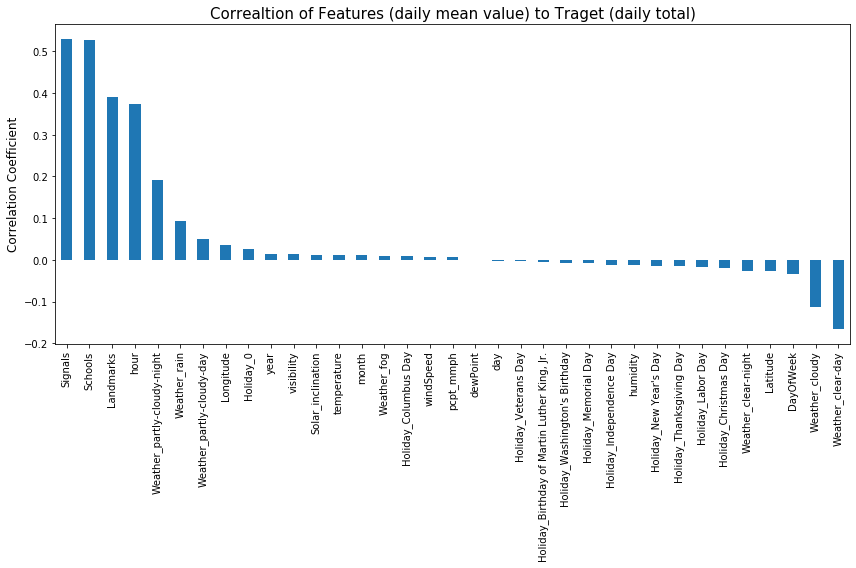

In [78]:
# Calculate the correlation coefficients between the features to the number of accidents
corr_with_Accident = df_d.corr()['Accident'].sort_values(ascending=False)
# plot
fig, ax = plt.subplots(figsize=(12, 8))
corr_with_Accident.drop('Accident').plot.bar()
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.title('Correaltion of Features (daily mean value) to Traget (daily total)',
          fontsize=15)
plt.tight_layout()
plt.savefig('Feat_correlation_to_target.pdf')

#### Feature-target separation:

In [79]:
# Separate the features and target from the whole datafile df_d.
Xddf = df_d.drop(columns=['Accident'])
yd = df_d['Accident']

#### Normalize the features:

In [80]:
# Normalize the data so that each of the columns will 
# have mean zero and standard deviation 1.
scaler = StandardScaler()
# Fit the data with scaler and save in pandas fomat
Xd = pd.DataFrame(scaler.fit_transform(Xddf.values),
                  index=Xddf.index, columns=Xddf.columns)

#### Train-test split on the basis of the time of incidence, prior incidences are taken as test set:

In [81]:
seed = 33
test_size = 0.2
# Split data as train and test sets. It will split dataset
# without changing time order.
Xd_train, Xd_test, yd_train, yd_test, col_list = split_data(df_d)
# It will split the data randomly test-size fraction
# will be separated as test set and remaining as train set.
# Xd_train, Xd_test, yd_train, yd_test = \
            # train_test_split(Xd, yd, test_size=test_size,
            # random_state=seed)

#### Sparse the dataframe format to the feature-target matrix (DMatrix: a step for xgb) 

In [82]:
# Optimizes the data structures internally for making 
# the memory efficiency and training speed.
dtraining = xgb.DMatrix(data=Xd, label=yd)
data_train = xgb.DMatrix(data=Xd_train, label=yd_train)
data_test = xgb.DMatrix(data=Xd_test, label=yd_test)

/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


#### Tuning the hyperparameters:

In [83]:
xgb1 = XGBRegressor() 
params = { 'objective':['reg:linear'],
                      'learning_rate': np.arange(0.05,1,0.05), 
                      'max_depth': np.arange(3,10,1),
                      'min_child_weight': np.arange(2,5,1),
                      'silent': [1],
                      'subsample': np.arange(0.5,0.8,0.1),
                      'colsample_bytree': np.arange(0.6,0.9,0.1),
                      'n_estimators': np.arange(10,100,20),
                      'alpha': np.arange(2,20,4)}

xgb_randcv = RandomizedSearchCV(xgb1, params,
                        #scoring='neg_mean_squared_error',
                        # this line can be commented to use XGB's default metric
                        cv = 5, n_iter=2,
                        n_jobs =1,
                        verbose=0)


#### Train and predict:

In [84]:
# Fit the training data and predict
xgb_randcv.fit(Xd_train, yd_train);

/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Se

In [85]:
best_param = xgb_randcv.best_params_

In [86]:
xgb_model = xgb.train(dtrain=data_train,
                       params=best_param,
                       num_boost_round=100)
    

In [87]:
preds = xgb_model.predict(data_test)

In [88]:
# Predicted data in the pandas frame
y_pred = pd.DataFrame({'Predicted': preds}).reset_index()
# Formatting the test set of the data
ytest_new = pd.DataFrame(yd_test.reset_index(drop=False)).reset_index()
# Merge the test data and predicted data and sort
# the file in the ascending order of accidents
test_pred = pd.merge(ytest_new, y_pred, on='index',
                     how='inner').drop('index', axis=1)

#### Errors:

In [89]:
rmse_mae(test_pred.Accident, test_pred.Predicted)

R_Square: 0.61 
Root mean squared error (RMSE): 1.113 
The mean absolute percentage error (MAPE): 33.58 % 
Accuracy: 66 %


(0.6059380813803434, 1.1129649727442306, 0.33582311060379394)

#### Cross-validaiton:

In [90]:
# Cross validation
params = {"objective":"reg:linear",
          'colsample_bytree': 0.9,
          'learning_rate': 0.1,
          'subsample': 0.6,
          'n_estimator': 100, 
          'min_child_weight': 4,
          'max_depth': 9, 'alpha': 14}

cv_results = xgb.cv(dtrain=data_train, params=params, nfold=5,
                    num_boost_round=100, early_stopping_rounds=10,
                    metrics="rmse", as_pandas=True, seed=111)

[14:10:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:10:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:10:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:10:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[14:10:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [91]:
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,2.219012,0.002830,2.221465,0.017352
1,2.072995,0.003332,2.078163,0.015498
2,1.944557,0.003724,1.952642,0.013328
3,1.831933,0.003637,1.842938,0.011817
4,1.733364,0.005250,1.747358,0.008349
...,...,...,...,...
95,0.804084,0.001807,1.064355,0.007339
96,0.802103,0.002112,1.063962,0.007574
97,0.800240,0.002074,1.063751,0.007664
98,0.798180,0.002206,1.063675,0.007891


#### Plot the cross-validation scores:

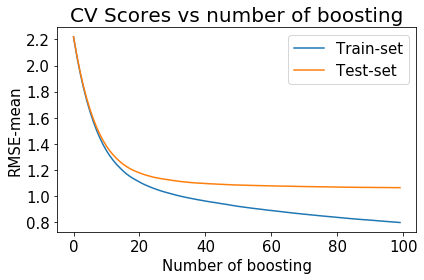

In [93]:
fig, ax = plt.subplots()
x_range = len(cv_results)
ax.plot(range(x_range), cv_results[['train-rmse-mean']], label='Train-set')
ax.plot(range(x_range), cv_results[['test-rmse-mean']], label='Test-set')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Number of boosting', fontsize=15)
plt.ylabel('RMSE-mean', fontsize=15)
plt.title('CV Scores vs number of boosting',
          fontsize=20)
plt.legend(fontsize=15)
ax.figure.tight_layout()
plt.tight_layout()
plt.savefig('cv_xgb_scores.pdf')

#### Feature importance: 
Here, the feature 'hour' has the largest F score. The importance of the features are shown in the following figure. 

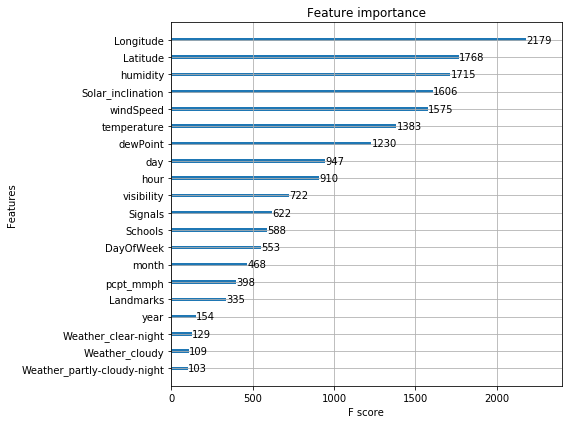

In [96]:
ax = xgb.plot_importance(xgb_model, max_num_features=20)
plt.rcParams['figure.figsize'] = [8, 6]
ax.figure.tight_layout()
plt.tight_layout()
plt.savefig('Feat_importances_xgb-daily.pdf')

#### Locationwise total accidents:

In [97]:
TP_Loc = test_pred.groupby('Location').sum()

#### Errors for the locationwise total accidents, compare the performance to the Random Forest model:

In [98]:
xgb_loc_rsq, xgb_loc_rmse, xgb_loc_mape = \
             rmse_mae(TP_Loc.Accident, TP_Loc.Predicted)

rsq_xgbrf_loc = (-xgb_loc_rsq + rf_loc_rsq) / rf_loc_rsq
rmse_xgbrf_loc = (-xgb_loc_rmse + rf_loc_rmse) / rf_loc_rmse
mape_xgbrf_loc = 100 * (-xgb_loc_mape + rf_loc_mape) / rf_loc_mape
print('\nPerfomance of XGB'
      ' over RF model for prediction of locationwise total accident'
      '(MAPE): %.0f'  %  mape_xgbrf_loc,  '%')
print('')


R_Square: 1.00 
Root mean squared error (RMSE): 9.599 
The mean absolute percentage error (MAPE): 6.05 % 
Accuracy: 94 %

Perfomance of XGB over RF model for prediction of locationwise total accident(MAPE): 45 %



#### Compare at different locations: Plot actual vs predicted:

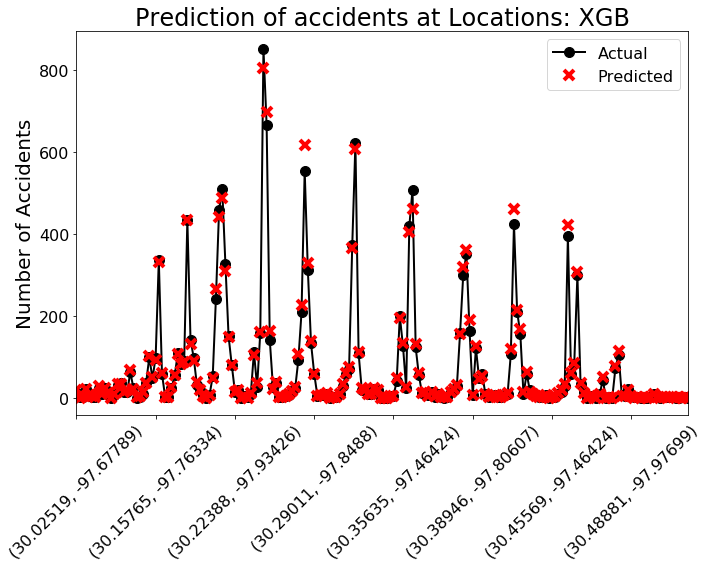

In [104]:
fig, ax = plt.subplots(figsize=(10, 8))
TP_Loc['Accident'].plot(label='Actual',
                       marker='o',
                       markersize=10,
                       linewidth=2,
                       color='k',
                       ax=ax)
TP_Loc['Predicted'].plot(label='Predicted',
                        marker='x',
                        markersize=10,
                        markeredgewidth=4,
                        linewidth=0, 
                        ax=ax,
                        color='r')
plt.xticks(rotation=45, fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
plt.xlabel('')
plt.ylabel('Number of Accidents', fontsize=20)
plt.title('Prediction of accidents at Locations: XGB', fontsize=24)
plt.tight_layout()
plt.savefig('xgb_location_accidents.pdf')

#### Split the string type location to the latitude and longitude columns:

In [106]:
# Extract the longitude and latitude data from the
# column "Location" column of the 'TP_Loc'.
TP_l = TP_Loc.reset_index().Location.str.replace(r'[^(]*\(|\)[^)]*', '')
TP_loc = pd.DataFrame(TP_l.map(lambda x: x.split(',')).values.tolist(),
                    columns=['lat', 'long'])
TP_lc = TP_Loc.reset_index().reset_index(). \
             merge(TP_loc.reset_index(), on='index'). \
    drop(['Location', 'index'], axis=1)
TP_lc['lat'] = TP_lc['lat'].astype(float)
TP_lc['long'] = TP_lc['long'].astype(float)

####  Using Folium plugins to plot the error and total accidents at the locations:
Green circles represent the total actual number of accidents at the specified location. The red circles carry the magnitudes of the mean absolute percentage errors (MAPE). The locations where total number of accidents are larger the errors are smaller and the locations with negligible number of accidents bear the larger MAPE.

In [107]:
from folium import CircleMarker
Austin_COORDINATES = (30.32, -97.7)
sf_map = folium.Map(location=Austin_COORDINATES, zoom_start=10.545)
heatmap1 = folium.plugins.HeatMap(TP_lc[['lat', 'long']], radius=5)
for i in range(len(TP_lc)):
    actual = float(TP_lc['Accident'][i])
    predicted = float(TP_lc['Predicted'][i])
    folium.CircleMarker(location=[TP_lc.lat[i], TP_lc.long[i]],
                        radius=abs(actual)*0.01,
                        popup=actual,
                        fill_opacity=0.01,color='green',
                        fill_color='green', fill=False).add_to(sf_map)
    folium.CircleMarker(location=[TP_lc.lat[i], TP_lc.long[i]],
                        radius=20*abs(actual-predicted)/abs(actual),
                        popup=20*abs(actual-predicted)/abs(actual),
                        fill_opacity=0.01, color='red', fill_color='green',
                        fill=False).add_to(sf_map)
sf_map.add_child(heatmap1)
sf_map.save('Geo_grid_predict.html')

#### Daily accidents throughout the city for XGB.

In [108]:
TP_time = test_pred.groupby('Date').sum()

#### Errors for daily accidents for XGB, compare the performance to the Random Forest model:

In [109]:
xgb_d_rsq, xgb_d_rmse, xgb_d_mape = \
        rmse_mae(TP_time.Accident, TP_time.Predicted)

rsq_perf_xgb = (rf_rsq - xgb_d_rsq) / rf_rsq
rmse_perf_xgb = (baseline_rmse - xgb_d_rmse) / rf_rmse
mape_perf_xgb = 100*(rf_mape - xgb_d_mape) / rf_mape
print('\nPerfomance of XGB'
      ' over RF model for prediction of daily accidents'
      '(MAPE): %.0f'  %  mape_perf_xgb,  '%')
print('')


R_Square: 0.80 
Root mean squared error (RMSE): 10.086 
The mean absolute percentage error (MAPE): 8.09 % 
Accuracy: 92 %

Perfomance of XGB over RF model for prediction of daily accidents(MAPE): 6 %



#### Graph showing the actual and predicted test data along with the actual training data for daily accidents in the city 

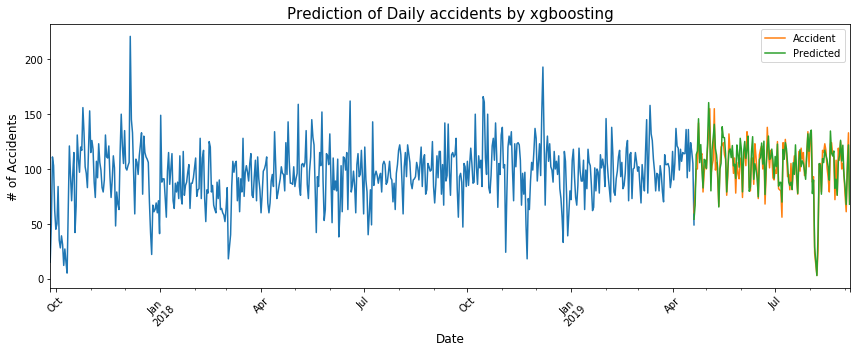

In [123]:
# Plot the daily predicted daily accident along with the actual data. 
yd_train = yd_train.groupby('Date').sum()
fig, ax = plt.subplots(figsize=(12,5))
yd_train.plot(ax=ax)
TP_time.plot(ax=ax)
plt.xticks(rotation=45)
plt.ylabel('# of Accidents', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.title('Prediction of Daily accidents by xgboosting', fontsize=15)
plt.tight_layout()
plt.savefig('Daily_prediction_xgb.pdf')

#### Error for daily accidents at specific locations for XGB: for selected locaitons only

In [165]:
max_loc = test_pred.groupby(['Location']).count(). \
          sort_values('Date').tail(6).index.tolist()
new_data = pd.DataFrame(max_loc, columns=['Location']). \
           merge(test_pred, on='Location', how='inner'). \
           groupby(['Location', 'Date']).sum()

new_data.reset_index(inplace=True)
accuracy = []
for i in range(len(max_loc)):
    data_rmse = new_data[new_data['Location'] == max_loc[i]]
    _, _, acc = rmse_mae(data_rmse.Accident,
                         data_rmse.Predicted)
    accuracy.append((1-acc))

R_Square: 0.37 
Root mean squared error (RMSE): 1.716 
The mean absolute percentage error (MAPE): 33.69 % 
Accuracy: 66 %
R_Square: 0.41 
Root mean squared error (RMSE): 1.406 
The mean absolute percentage error (MAPE): 32.42 % 
Accuracy: 68 %
R_Square: 0.18 
Root mean squared error (RMSE): 2.060 
The mean absolute percentage error (MAPE): 33.27 % 
Accuracy: 67 %
R_Square: 0.29 
Root mean squared error (RMSE): 2.098 
The mean absolute percentage error (MAPE): 34.75 % 
Accuracy: 65 %
R_Square: 0.30 
Root mean squared error (RMSE): 1.644 
The mean absolute percentage error (MAPE): 30.89 % 
Accuracy: 69 %
R_Square: 0.17 
Root mean squared error (RMSE): 2.368 
The mean absolute percentage error (MAPE): 30.13 % 
Accuracy: 70 %


#### Plots of actual against predicted data: Locationwise
Each row represents for a particular locaiton

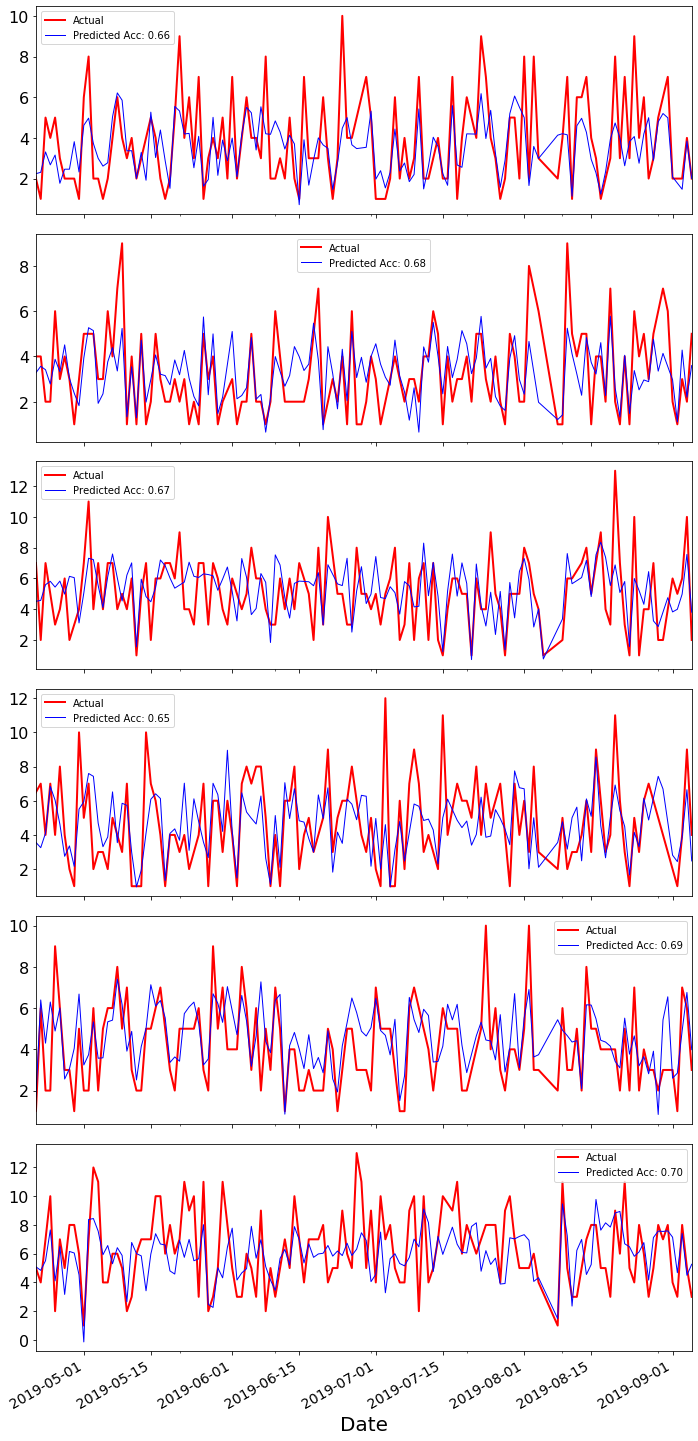

In [176]:
fig, ax = plt.subplots(len(max_loc), figsize=(10, 20), sharex=True)
for i in range(len(max_loc)):
    old_data = new_data[new_data['Location'] == max_loc[i]]. \
               groupby(['Location', 'Date']).sum()
    if i == 0:
        all_data = old_data
    pd.DataFrame(old_data.reset_index().drop('Location', axis=1). \
                 set_index(['Date'], drop=True))['Accident']. \
                 plot(label='Actual',
                      ax=ax[i],
                      marker='o',
                      markersize=0,
                      color='r',
                      legend=True,
                      linewidth=2)
    pd.DataFrame(old_data.reset_index().drop('Location', axis=1). \
                 set_index(['Date'], drop=True))['Predicted']. \
                 plot(label='Predicted Acc: %.2f' %accuracy[i],
                      ax=ax[i],
                      marker='x',
                      markersize=0,
                      markeredgewidth=3,
                      linewidth=1,
                      fontsize=16,
                      color='b',
                      legend=True)
    plt.xticks(rotation=30, fontsize=14)
    if i > 0:
        all_data = pd.merge(all_data, old_data, on='Date', how = 'outer')
plt.tight_layout()
plt.xlabel('Date', fontsize=20)
plt.savefig('Locationwise_xgb.pdf')

### b. XGBRegessor for Hourly data 

####  Feature selections:

In [8]:
df1 = df0.groupby(['hour', 'Location']).sum()['Accident']
df2 = df0.groupby(['hour', 'Location']). \
        mean()[['Latitude', 'Longitude',
                'Signals', 'Landmarks',
                'Schools', 'windSpeed', 'visibility',
                'pcpt_mmph', 'temperature', 'dewPoint',
                'Solar_inclination', 'humidity']]
df3 = df0[['Location', 'day', 'month',
           'DayOfWeek', 'hour', 'year',
           'Weather', 'Holiday']].groupby(['hour', 'Location']).max()

In [9]:
df3_oh = pd.get_dummies(df3)

In [10]:
df_mid = pd.merge(df2, df3_oh,
                  on=['hour', 'Location'],
                  how='inner')

df = pd.merge(df_mid, df1, on=['hour', 'Location'], how='inner')

In [11]:
corr_with_Accident = df.corr()['Accident'].sort_values(ascending=False)

#### Correlation of features to the hourly accidents:
As seen for the daily accidents, features like number of schools, traffic signals and historical landmarks are strongly correlated to the hourly accidents. Weather and other features also have the similar correlations as for the daily accidents. 

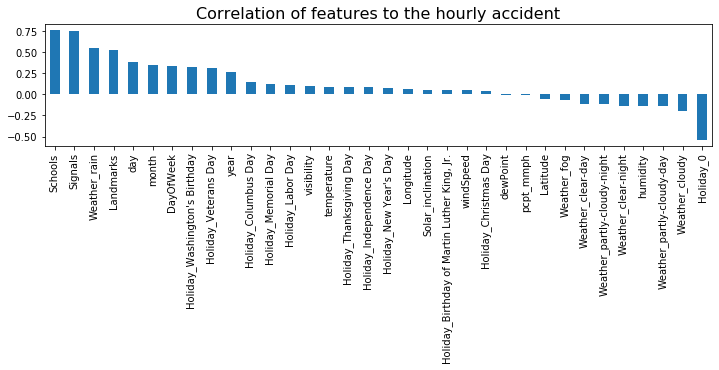

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
ax = corr_with_Accident.drop('Accident').plot.bar()
plt.tight_layout()
plt.xticks(rotation=90)
ax = plt.title('Correlation of features to the hourly accident', fontsize=16)
plt.savefig('Correlation_with_Accident.pdf')

#### Feature, label separation:

In [13]:
Xdf = df.drop(columns=['Accident'])
y = df['Accident']

#### Scaled to normal distribution:

In [14]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(Xdf.values), index=Xdf.index, columns=Xdf.columns)

#### train, test splitting. Random splitting. 
We split randomly, so that it will predict the average number of accidents at a particular hour of any day of the year.

In [15]:
X_train, X_test, y_train, y_test, col_list = split_data(df, time_series=False)

#### Sparse the dataframe into matrix

In [16]:
data_dmatrix = xgb.DMatrix(data=X, label=y)
data_train = xgb.DMatrix(data=X_train, label=y_train)
data_test = xgb.DMatrix(data=X_test, label=y_test)

/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [17]:
xgb1 = XGBRegressor() 
params = { 'objective':['reg:linear'],
                      'learning_rate': np.arange(0.05,1,0.05), 
                      'max_depth': np.arange(3,10,1),
                      'min_child_weight': np.arange(2,5,2),
                      'silent': [1],
                      'subsample': np.arange(0.5,0.8,0.1),
                      'colsample_bytree': np.arange(0.6,0.9,0.1),
                      'n_estimators': np.arange(10,500,20),
                      'alpha': np.arange(2,20,4)}

xgb_randcv = RandomizedSearchCV(xgb1, params,
                        #scoring='neg_mean_squared_error',
                        # this line can be commented to use XGB's default metric
                        cv = 5, n_iter=10,
                        n_jobs =1,
                        verbose=0)


In [18]:
xgb_randcv.fit(X_train, y_train)

/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Se

/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Se

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_st...
                                        'max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'min_child_weight': array([2, 4]),
                               

In [19]:
xgb_hour_best = xgb_randcv.best_score_
xgb_hour_best_params = xgb_randcv.best_params_
xgb_hour_best_params

{'subsample': 0.7999999999999999,
 'silent': 1,
 'objective': 'reg:linear',
 'n_estimators': 210,
 'min_child_weight': 4,
 'max_depth': 3,
 'learning_rate': 0.25,
 'colsample_bytree': 0.7999999999999999,
 'alpha': 10}

In [20]:
xgb_hour_model = xgb.train(dtrain=data_train,
                           params=xgb_hour_best_params,
                           num_boost_round=100)

#### Cross-validations:

In [21]:
cv_results = xgb.cv(dtrain=data_train,
                    params=xgb_hour_best_params,
                    nfold=5, num_boost_round=500,
                    early_stopping_rounds=20,
                    metrics="rmse",
                    as_pandas=True, seed=123)

In [22]:
print(cv_results.head())

   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
0        32.006118        0.469570       32.106392       2.118943
1        26.403302        0.505341       26.750260       1.766822
2        22.319451        0.531953       22.972925       1.861745
3        19.286360        0.386565       20.146097       1.718413
4        17.184096        0.315552       18.255305       1.540773


#### Plot CV as number of boosting

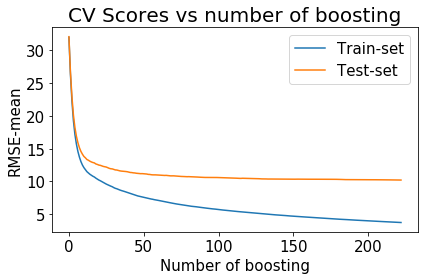

In [23]:
fig, ax=plt.subplots()
x_range=len(cv_results)
ax.plot(range(x_range), cv_results[['train-rmse-mean']], label='Train-set')
ax.plot(range(x_range), cv_results[['test-rmse-mean']], label='Test-set')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Number of boosting', fontsize=15)
plt.ylabel('RMSE-mean', fontsize=15)
plt.title('CV Scores vs number of boosting',
          fontsize=20)
plt.legend(fontsize=15)
ax.figure.tight_layout()
plt.tight_layout()
plt.savefig('cv_xgb-hourly_scores.pdf')

#### Training with the number of boosting round corresponding to the minimum RMSE error:

In [24]:
xg_reg = xgb.train(params=xgb_hour_best_params,
                   dtrain=data_train,
                   num_boost_round=500)

In [25]:
preds = xg_reg.predict(data_test)

In [26]:
# pip install graphviz

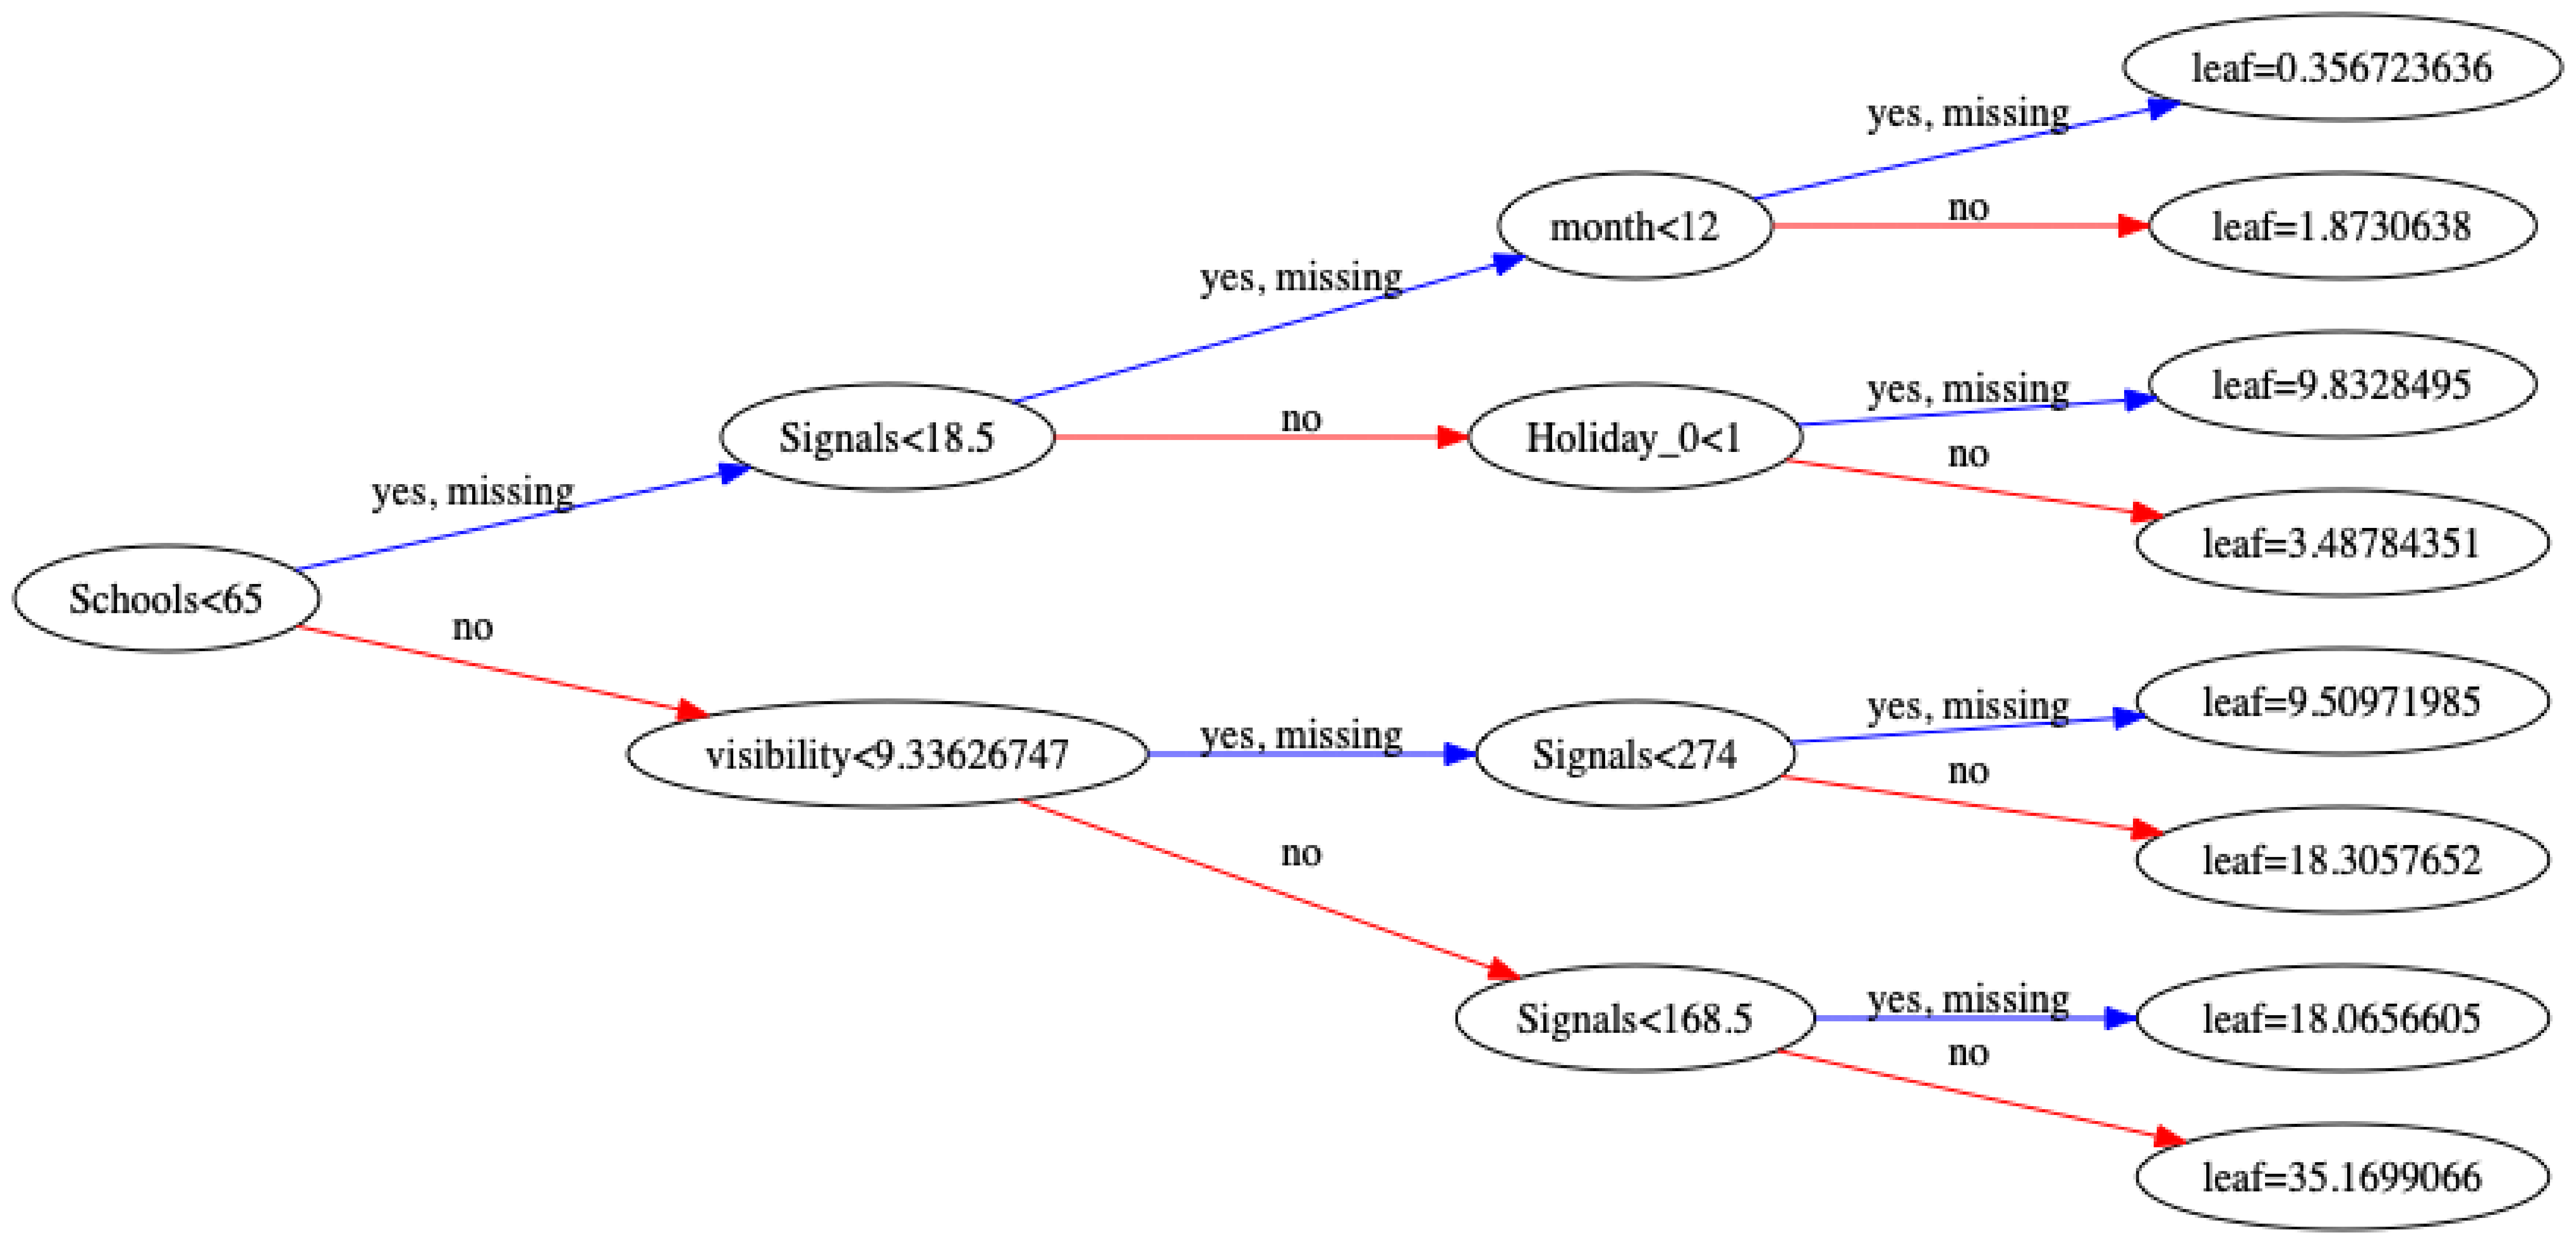

In [41]:
xgb.plot_tree(xg_reg, num_trees=1, rankdir='LR')
plt.rcParams['figure.figsize'] = [10,10]
fig = plt.gcf()
fig.set_size_inches(120,100)
plt.savefig('tree.pdf')

#### Feature importance:
Visibility, longitude, precipitation (rain) and solar inclination are the most important factors for causing the road accident when we analyze the data for hourly accidents. Weather related features such as Windspeed, latitude, humidity and temperature are also important equally. Again, historical landmarks, traffic signals, school zones, year, month, day, holidays are negligibly important.

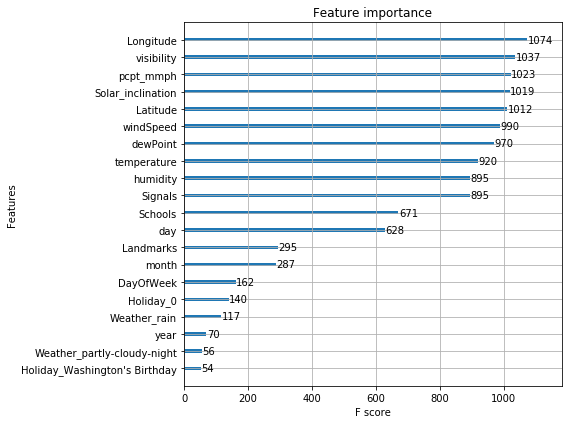

In [196]:
ax = xgb.plot_importance(xg_reg, max_num_features=20)
plt.rcParams['figure.figsize'] = [8, 6]
ax.figure.tight_layout()
plt.savefig('feature_importance.pdf')

#### Errors:

In [197]:
rmse_mae(y_test, preds)

R_Square: 0.93 
Root mean squared error (RMSE): 8.729 
The mean absolute percentage error (MAPE): 26.35 % 
Accuracy: 74 %


(0.9300274663085589, 8.72867311437921, 0.2635004887380809)

#### Formating actual and predicted data in single frame:

In [198]:
y_Pred = pd.DataFrame({'pred': preds}).reset_index()
y_Test = y_test.reset_index().reset_index()

In [199]:
ytotal = pd.merge(y_Pred, y_Test, on='index',
                  how='inner').drop('index', axis=1)
ytotal.sort_values('hour', inplace=True)
ytotal.reset_index(inplace=True)

#### Locationwise hourly count: 

##### we select the five location with maximum hours with at least one accident:

In [202]:
max_loc = ytotal.groupby(['Location']).count(). \
          sort_values('hour').tail(5).index.tolist()
new_data = pd.DataFrame(max_loc, columns=['Location']). \
           merge(ytotal, on='Location', how='inner'). \
           groupby(['Location', 'hour']).sum()

new_data.reset_index(inplace=True)
accuracy = []
for i in range(len(max_loc)):
    data_rmse = new_data[new_data['Location'] == max_loc[i]]
    _, _, acc = rmse_mae(data_rmse.Accident, data_rmse.pred)
    accuracy.append(1-acc)

R_Square: 0.75 
Root mean squared error (RMSE): 18.776 
The mean absolute percentage error (MAPE): 19.68 % 
Accuracy: 80 %
R_Square: 0.67 
Root mean squared error (RMSE): 0.683 
The mean absolute percentage error (MAPE): 25.72 % 
Accuracy: 74 %
R_Square: 0.22 
Root mean squared error (RMSE): 4.131 
The mean absolute percentage error (MAPE): 33.70 % 
Accuracy: 66 %
R_Square: 0.10 
Root mean squared error (RMSE): 4.131 
The mean absolute percentage error (MAPE): 49.04 % 
Accuracy: 51 %
R_Square: -3.82 
Root mean squared error (RMSE): 15.629 
The mean absolute percentage error (MAPE): 72.53 % 
Accuracy: 27 %


In [203]:
new_data1 = new_data.drop('index', axis=1)

#### Plot actual and predicted hourly accident counts at certain locations:

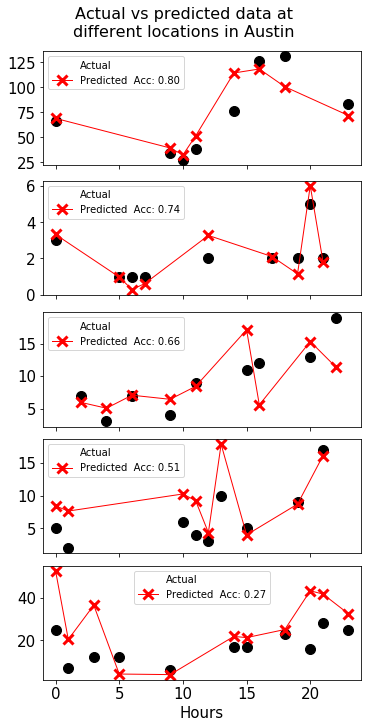

In [221]:
ncols = 1
nrows = int(len(max_loc)/ncols)
fig, axes = plt.subplots(nrows=nrows,
                       ncols=ncols,
                       figsize=(5, 10),
                       sharex=True,
                       constrained_layout=True,
                       sharey=False,)
fig.suptitle('Actual vs predicted data at\n'
             'different locations in Austin',
             fontsize=16)
for i in range(len(max_loc)):
    ij, ik = int(i // ncols), i % ncols
    old_data = new_data1[new_data1['Location'] == max_loc[i]]. \
               groupby(['Location', 'hour']).sum()
    if i == 0:
        all_data = old_data
    if ncols > 1:
        pd.DataFrame(old_data.reset_index().drop('Location', axis=1). \
                     set_index(['hour'], drop=True))['Accident']. \
                     plot(label='Actual',
                          ax=axes[ij][ik],
                          marker='o',
                          markersize=12,
                          markeredgewidth=1,
                          linewidth=1,
                          color='k',
                          legend=True)
    else:
        pd.DataFrame(old_data.reset_index().drop('Location', axis=1). \
                     set_index(['hour'], drop=True))['Accident']. \
                     plot(label='Actual',
                          ax=axes[i],
                          marker='o',
                          markersize=10,
                          markeredgewidth=1,
                          linewidth=0,
                          color='k',
                          legend=True,
                          fontsize=15)
        pd.DataFrame(old_data.reset_index().drop('Location', axis=1). \
                     set_index(['hour'], drop=True))['pred']. \
                     plot(label='Predicted  Acc: %0.2f' %accuracy[i],
                          ax=axes[i],
                          marker='x',
                          markersize=10,
                          markeredgewidth=3,
                          linewidth=1,
                          color='r',
                          legend=True,
                          fontsize=15)
    if ncols > 1:
        ax[-1][1].set_xlabel('Hours', fontsize=15)
    else:
        plt.xlabel('Hours', fontsize=15)
    plt.xticks(rotation=0)
    plt.xlim(-1, 24)
    #plt.tight_layout()
    if i > 0:
        all_data = pd.merge(all_data, old_data, on='hour', how='outer')
plt.savefig('xgb_hourly_locaitonwise.pdf')

#### Hourly totat number of accidents throughout the city of Austin:

/Users/rameshadhikari/anaconda3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  """


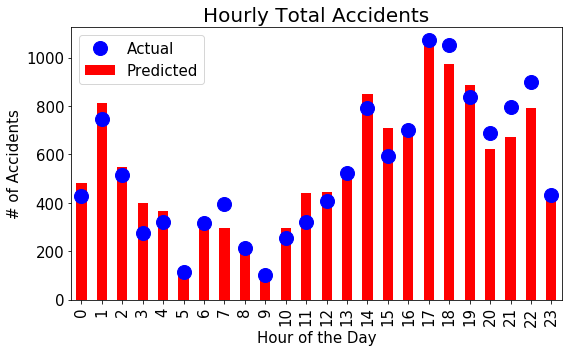

In [222]:
ytotal.hour=ytotal.hour.apply(int)
y_hour=ytotal.drop(['index'], axis=1).groupby('hour').sum()
fig,ax=plt.subplots(figsize=(8,5))
plt.plot(y_hour.Accident, marker='o', markersize=14, color = 'b', linewidth=0, label='Actual')
y_hour.pred.plot('bar', linewidth=1, label='Predicted', color='r')
plt.legend(loc=2, fontsize=15)
plt.title('Hourly Total Accidents', fontsize=20)
plt.xlabel('Hour of the Day', fontsize=15)
plt.ylabel('# of Accidents', fontsize=15)
plt.xticks(fontsize=15,rotation=90)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('Hourly_accidents_prediction.pdf')

#### Errors:

In [223]:
rmse_mae(y_hour.Accident, y_hour.pred)

R_Square: 0.94 
Root mean squared error (RMSE): 67.835 
The mean absolute percentage error (MAPE): 10.31 % 
Accuracy: 90 %


(0.939369643599057, 67.83473224571568, 0.10312240062405453)